# Library's used

#### 1] library(survival) -- The survival package is the cornerstone of the entire R survival analysis edifice.
#### 2] library(ggfortify) -- The ggfortify enables producing handsome, one-line survival plots with ggplot2::autoplot.
#### 3] library(ranger)--     The ranger() function is well-known for being a fast implementation of the Random Forests algorithm for building ensembles of classification and regression trees.



In [11]:
# install.packages("magrittr") 
# install.packages("ggfortify") 

In [2]:
library(survival)
library(ranger)
library(ggplot2)
library(dplyr)
library(ggfortify)


Warning message:
"package 'survival' was built under R version 3.6.3"Warning message:
"package 'ranger' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggfortify' was built under R version 3.6.3"

In [3]:

# trt-- Treatment 1,2
# celltype -- 1=squamous
#             2=small cell
#             3=adeno
#             4=large
# status -- censoring status
# karno -- Karnofsky performance score range(0 to 100) -- whether patients can perform ordinary tasks
# diagtime -- months from diagnosis to randomization 
# age -- in years 
# prior: prior therapy 0=no, 10=yes


In [4]:
# head(veteran)

In [5]:
veteran <- read.csv("dataset.csv")
head(veteran)

X,trt,celltype,time,status,karno,diagtime,age,prior
1,1,squamous,72,1,60,7,69,0
2,1,squamous,411,1,70,5,64,10
3,1,squamous,228,1,60,3,38,0
4,1,squamous,126,1,60,9,63,10
5,1,squamous,118,1,70,11,65,10
6,1,squamous,10,1,20,5,49,0


## survfit() function to produce the Kaplan-Meier estimates of the probability of survival over time. 


In [6]:
# Kaplan Meier Survival Curve
km <- with(veteran, Surv(time, status))
km_fit <- survfit(Surv(time, status) ~ 1, data=veteran)
# summary(km_fit, times = c(1,30,60,90*(1:10)))
# plot(km_fit, xlab="Days", main = 'Kaplan Meyer Plot')

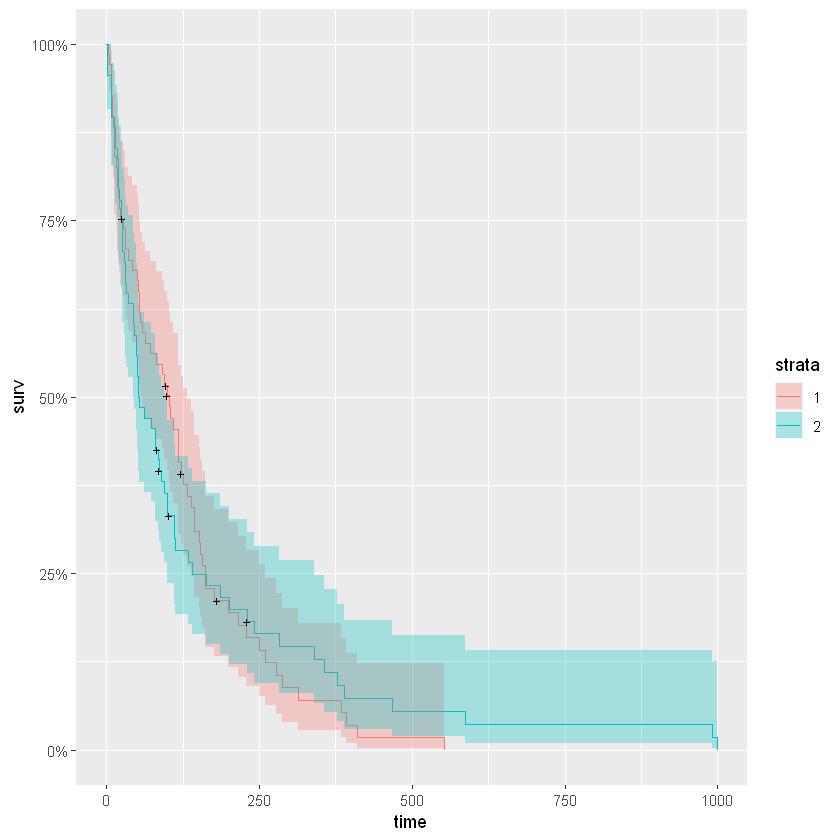

In [7]:
km_trt_fit <- survfit(Surv(time, status) ~ trt, data=veteran)
autoplot(km_trt_fit)

## Survival by age

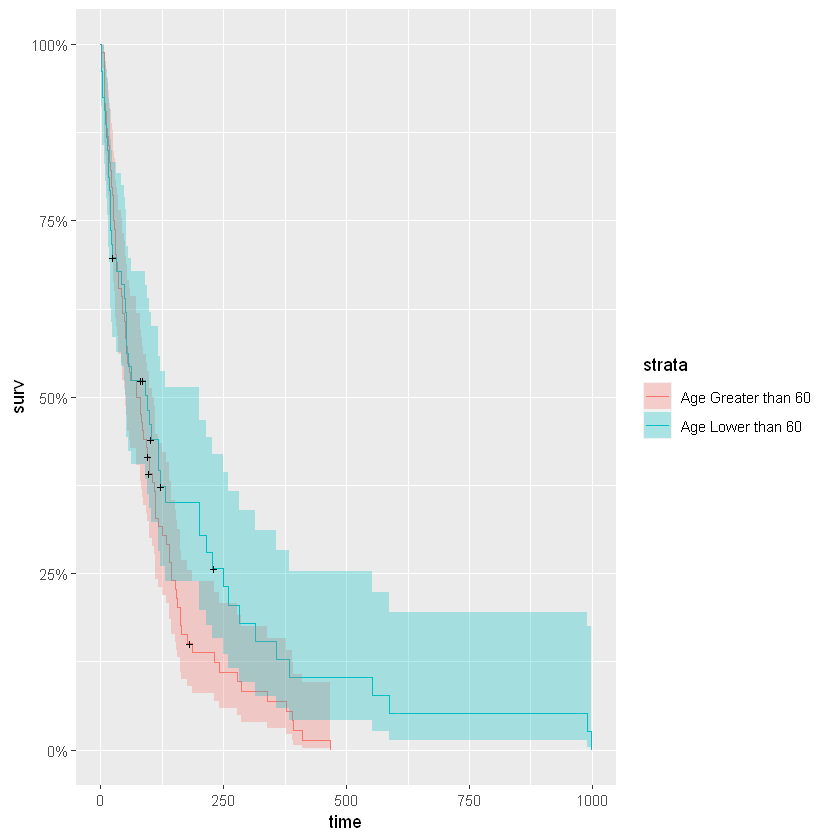

In [8]:
vet <- mutate(veteran, AG = ifelse((age < 60), "Age Lower than 60", "Age Greater than 60"),
              AG = factor(AG),
              trt = factor(trt,labels=c("standard","test")),
              prior = factor(prior,labels=c("N0","Yes")))

km_AG_fit <- survfit(Surv(time, status) ~ AG, data=vet)
autoplot(km_AG_fit)


# Overlap in the first fifty days, younger patients clearly have a better chance of surviving more than a year.

# Cox Proportional Hazards Model

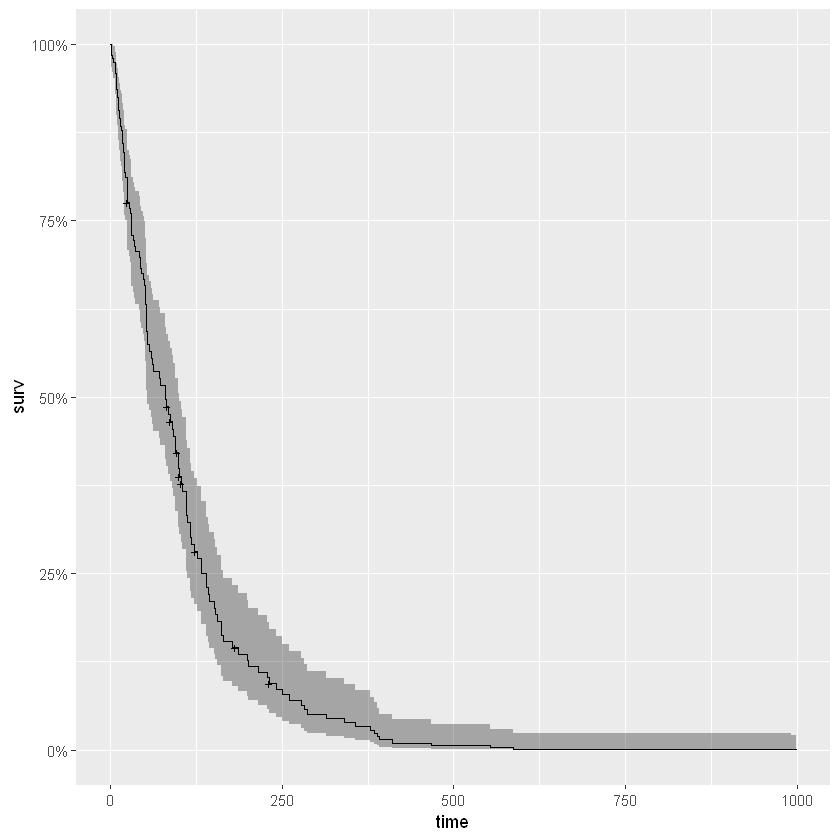

In [9]:
cox <- coxph(Surv(time, status) ~ trt + celltype + karno + diagtime + age + prior , data = vet)
# summary(cox)
cox_fit <- survfit(cox)
autoplot(cox_fit)

# Additive regression model 

Warning message:
"`mutate_()` was deprecated in dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."Warning message:
"`group_by_()` was deprecated in dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."

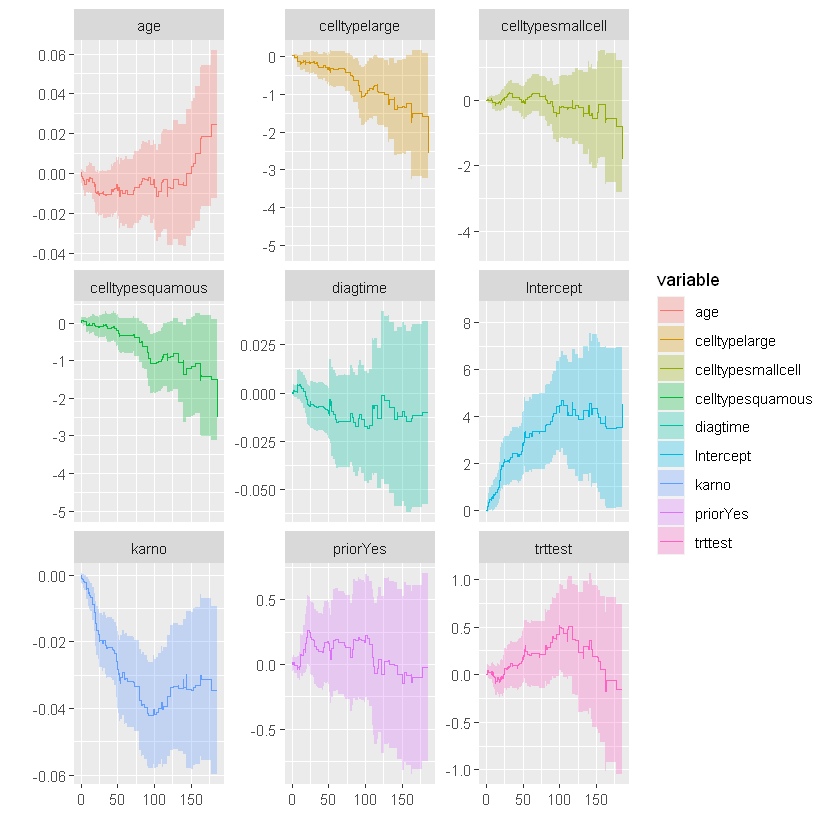

In [10]:
aa_fit <-aareg(Surv(time, status) ~ trt + celltype +
                 karno + diagtime + age + prior , 
                 data = vet)
# summary(aa_fit)
autoplot(aa_fit)

# Random Forests Model

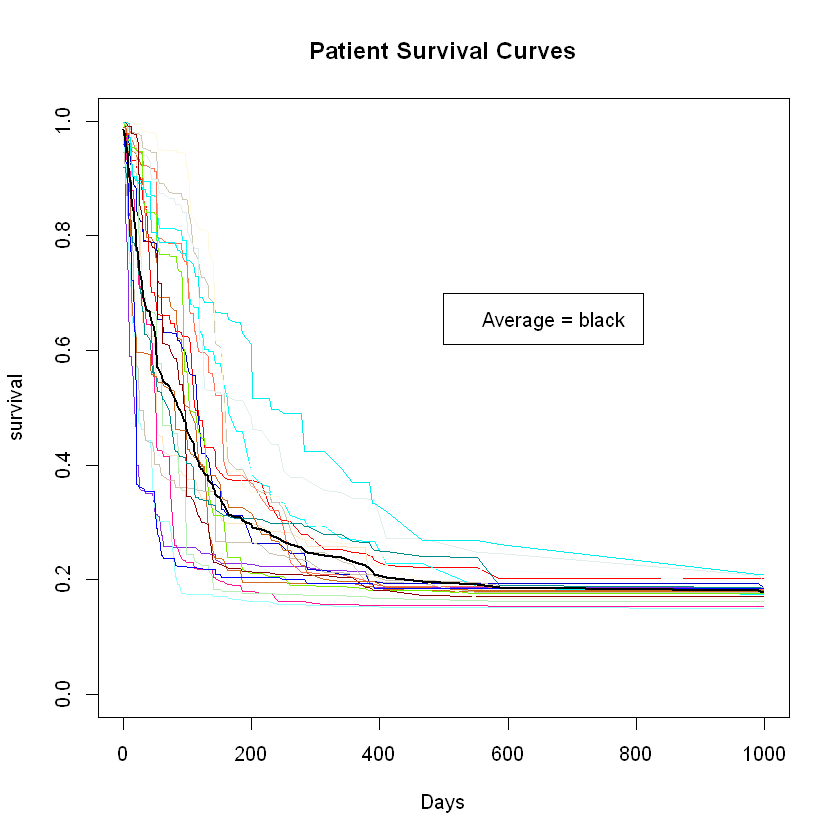

In [11]:

r_fit <- ranger(Surv(time, status) ~ trt + celltype + 
                     karno + diagtime + age + prior,
                     data = vet,
                     mtry = 4,
                     importance = "permutation",
                     splitrule = "extratrees",
                     verbose = TRUE)

# Average the survival models
death_times <- r_fit$unique.death.times 
surv_prob <- data.frame(r_fit$survival)
avg_prob <- sapply(surv_prob,mean)

# Plot the survival models for each patient
plot(r_fit$unique.death.times,r_fit$survival[1,], 
     type = "l", 
     ylim = c(0,1),
     col = "red",
     xlab = "Days",
     ylab = "survival",
     main = "Patient Survival Curves")

#
cols <- colors()
for (n in sample(c(2:dim(vet)[1]), 20)){
  lines(r_fit$unique.death.times, r_fit$survival[n,], type = "l", col = cols[n])
}
lines(death_times, avg_prob, lwd = 2)
legend(500, 0.7, legend = c('Average = black'))

In [12]:
vi <- data.frame(sort(round(r_fit$variable.importance, 4), decreasing = TRUE))
names(vi) <- "Importance"
head(vi)

,Importance
karno,0.0897
celltype,0.0316
diagtime,0.0009
prior,-0.0003
trt,-0.0006
age,-0.0039


In [22]:
# cat("Prediction Error = 1 - Harrell's c-index = ", r_fit$prediction.error)

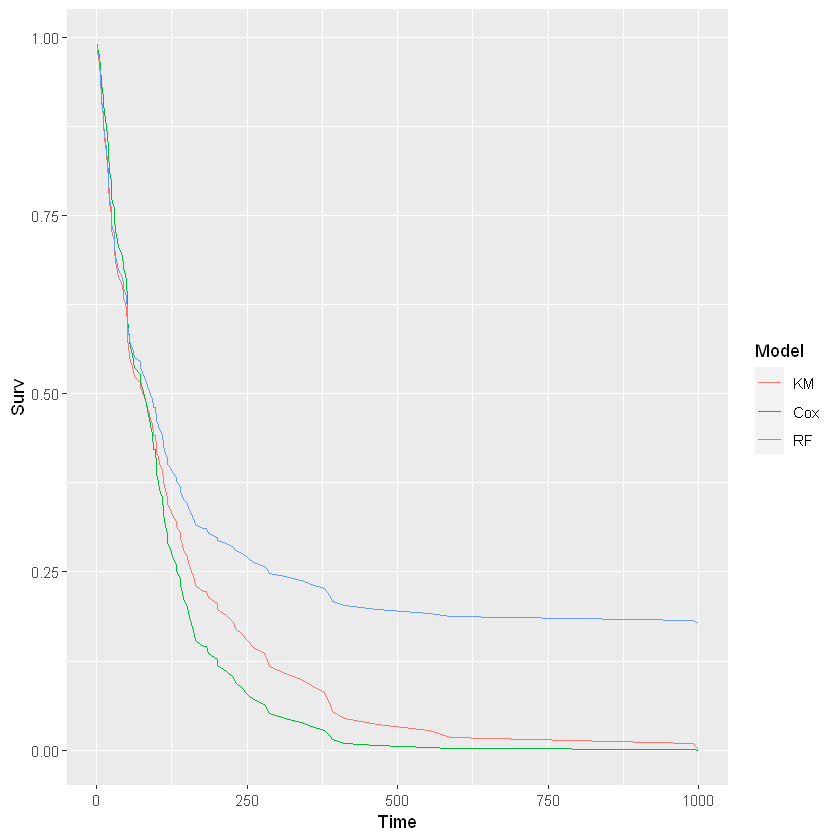

In [25]:
# Set up for ggplot
kmi <- rep("KM",length(km_fit$time))
km_df <- data.frame(km_fit$time,km_fit$surv,kmi)
names(km_df) <- c("Time","Surv","Model")

coxi <- rep("Cox",length(cox_fit$time))
cox_df <- data.frame(cox_fit$time,cox_fit$surv,coxi)
names(cox_df) <- c("Time","Surv","Model")

rfi <- rep("RF",length(r_fit$unique.death.times))
rf_df <- data.frame(r_fit$unique.death.times,avg_prob,rfi)
names(rf_df) <- c("Time","Surv","Model")

plot_df <- rbind(km_df,cox_df,rf_df)

p <- ggplot(plot_df, aes(x = Time, y = Surv, color = Model))
p + geom_line()